In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

from rflearn.algo import MCEpsilonSoft, TabularQValue, TabularPolicy
from rflearn.env import MultiArmBandit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MC Eps Soft with Batch

In [3]:
np.random.seed(234728375)

params = {
    'epsilon': [0.1],
    'alpha': [0.01, 0.1, 0.5, 1.0, None],
}
nA = 10
gamma = 1
runs = 200
steps = 1000
max_steps = 1
kbatch = 1

bandit = MultiArmBandit(nA, moving_target=False)
data = {} # trace for each combination of hyperparameters
for eps, alpha in product(params['epsilon'], params['alpha']):
    trace = []  # one trace average up over all runs for one comb
    for i in tqdm(range(runs), leave=True):
        qvalue = TabularQValue(bandit.S, bandit.A)
        policy = TabularPolicy(bandit.S, bandit.A, epsilon=eps)
        mc_model = MCEpsilonSoft(bandit, qvalue, policy)
        mc_model.fit(gamma=gamma, alpha=alpha)
        mc_model.transform(steps, kbatch=kbatch, max_steps=max_steps, pbar_leave=False)

        stats = []  # one run of statistics
        for step in mc_model.hist:
            avg_r = step[kbatch-1].get_total_rewards()
            optimal_a = step[kbatch-1][max_steps-1].a0 == np.argmax(bandit._truth)
            stats.append(optimal_a)
        trace.append(stats)

    name = f'<ϵ: {eps}, α: {alpha}>'
    data[name] = pd.DataFrame(trace).mean(0)  # sum over rows

100%|██████████| 200/200 [00:20<00:00,  9.55it/s]


Text(0.5, 1.0, 'Optimal Action %')

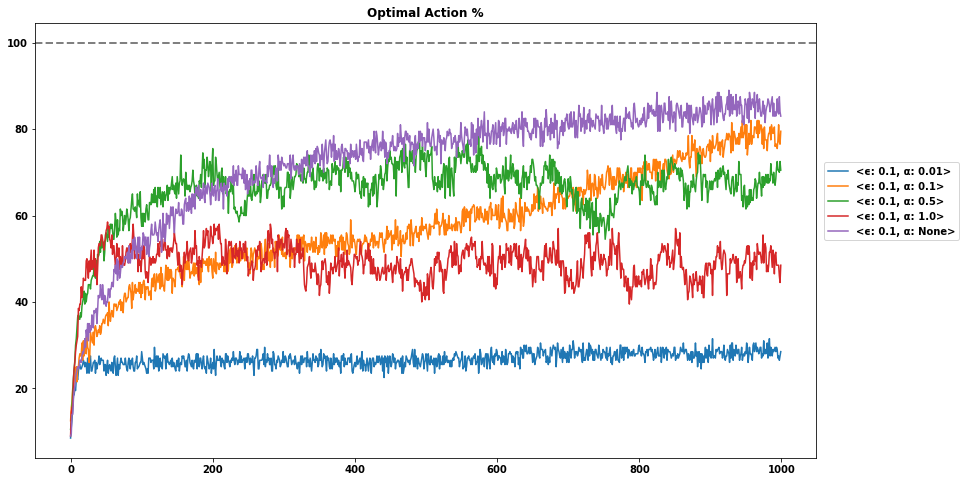

In [10]:
plt.figure(figsize=(14,8))
for k, v in data.items():
    (v*100).plot(label=k)
plt.axhline(100, linestyle='--', linewidth=2, color='grey')
plt.legend(loc=(1.01,0.5))
plt.title('Optimal Action %')